In [50]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import sys
import itertools
import scipy.signal as sig
import shutil
import os
from pathlib import Path
import cv2
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle, Polygon
from collections import OrderedDict
import scipy.stats as scs
import scipy.signal as sig

import torch
import torchvision.transforms as transforms
from torchvision.models import resnet18, squeezenet1_0
from torch.utils import data as torchdata

from sklearn.metrics import pairwise_distances 
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split

from src.data.dataset import ImageFilesDataset, ImageFilesDatasetBox, get_bounding_box_dataset
import src.utils as utils
from src.vision.transforms import *
from src.data.clip import *
import logging
from logging.config import fileConfig

from src.models.models import *
import pytesseract
from imutils.object_detection import non_max_suppression
from src.features.court_bounding_boxes import *
from src.features.extract_scoreboard import *
code_path = Path("/Users/shendrickson/Downloads/opencv-text-recognition/")

fileConfig('../logging_config.ini')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [51]:
frame_path = Path("../data/processed/frames/")

video_frames = list(frame_path.iterdir())
clip_path = Path("../data/interim/clips/")

videos = [Video.from_dir(v) for v in video_frames]
videos

[anderson_federer_wim_18,
 coric_federer_halle_18,
 djokovic_anderson_wim_18,
 federer_cilic_aus_18,
 federer_nadal_iw_17,
 federer_tsonga_montecarlo_14,
 haase_zverev_cincinnati_18,
 nadal_marterer_french_18,
 nadal_monfils_montecarlo_16,
 nadal_tsitsipas_barcelona_18,
 osaka_halep_rome_18,
 zverev_isner_miami_18]

In [143]:
im_size = 256
# features = np.load(Path("../data/interim/featurized_frames/") / (video.name + ".npy"))
match = videos[0]
match_name = match.name
ds = ImageFilesDataset(match.frames)
tfms = transforms.Compose([
    transforms.ToTensor(),
    TorchImageToNumpy()])
ds = ds.with_transforms(tfms)
match_metas = utils.get_match_metadata(Path("../src/match_meta.txt"))
# loader = torchdata.DataLoader(ds.with_transforms(tfms), batch_size=16, num_workers=4)

In [159]:
meta_file = "../src/match_meta.json"
with open(meta_file, 'r') as f:
    match_metas = json.load(f)

In [160]:
if match_name not in match_metas:
    match_meta = {"box": [67, 17, 145, 27],
    "min_score_text_width": 5,
    "min_score_text_height": 5,
    "invert": True,
    "score_thresh_low": 150,
    "min_score_width": 80}
else:
    match_meta = match_metas[match_name]

In [162]:
match_meta['invert']

True

In [147]:
# match_meta = {"box": [67, 17, 145, 27],
#     "min_score_text_width": 5,
#     "min_score_text_height": 5,
#     "invert": True,
#     "score_thresh_low": 150,
#     "min_score_width": 80}

In [148]:
match_metas.keys()

dict_keys(['coric_federer_halle_18', 'federer_cilic_aus_18', 'anderson_federer_wim_18', 'federer_nadal_iw_17', 'haase_zverev_cincinnati_18', 'federer_tsonga_montecarlo_14', 'nadal_marterer_french_18', 'nadal_monfils_montecarlo_16', 'nadal_tsitsipas_barcelona_18', 'zverev_isner_miami_18', 'osaka_halep_rome_18', 'djokovic_anderson_wim_18'])

[67, 17, 145, 27]


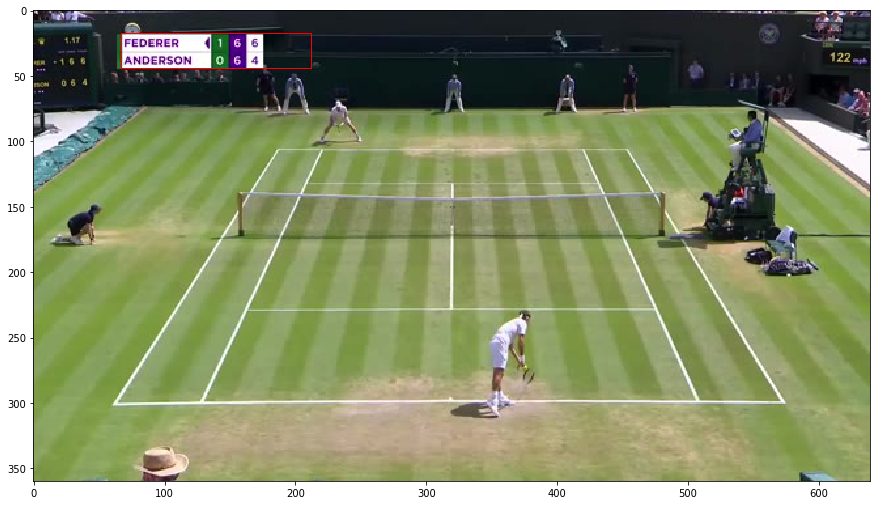

In [149]:
idx = 12
fig, ax = plt.subplots(1, 1, figsize=(15, 12))
im = ds[idx][0]
ax.imshow(im)
x, y, w, h = match_meta['box']
print(match_meta['box'])
rect = Rectangle((x, y), w, h, linewidth=1, edgecolor='r', facecolor='none')
ax.add_patch(rect)

In [150]:
invert = match_meta['invert']
min_w = match_meta['min_score_text_width']
min_h = match_meta['min_score_text_height']
thresh_low = match_meta["score_thresh_low"]

In [151]:
img = (im[y:y+h, x:x+w] * 255)
img = 255 - img if invert else img
img = img.astype(np.uint8)

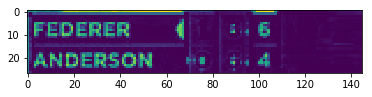

In [152]:
dilated, g = dilate_image(img, thresh_low=thresh_low)
plt.imshow(g)

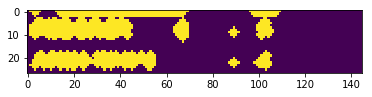

In [153]:
plt.imshow(dilated)

In [154]:
score_width = find_text(dilated, min_w=min_w, min_h=min_h)
print(score_width)

110


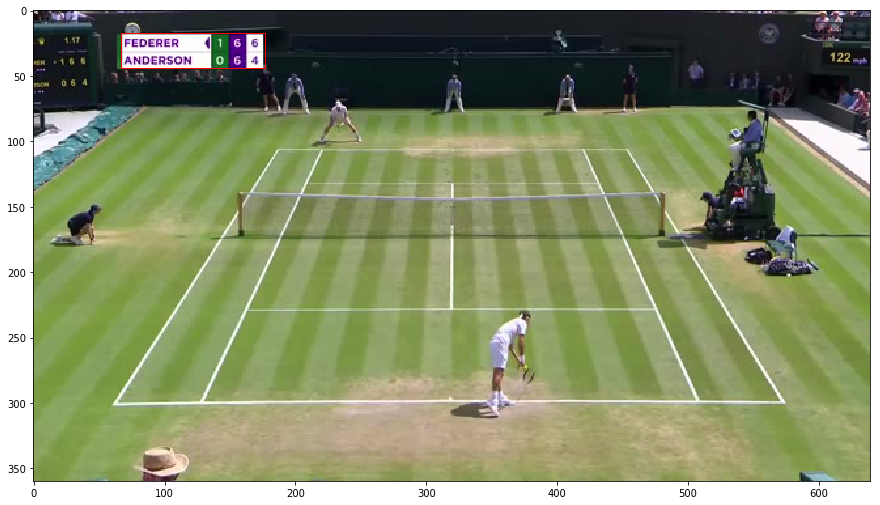

In [155]:
fig, ax = plt.subplots(1, 1, figsize=(15, 12))
ax.imshow(im)
rect = Rectangle((x, y), score_width, h, linewidth=1, edgecolor='r', facecolor='none')
ax.add_patch(rect)

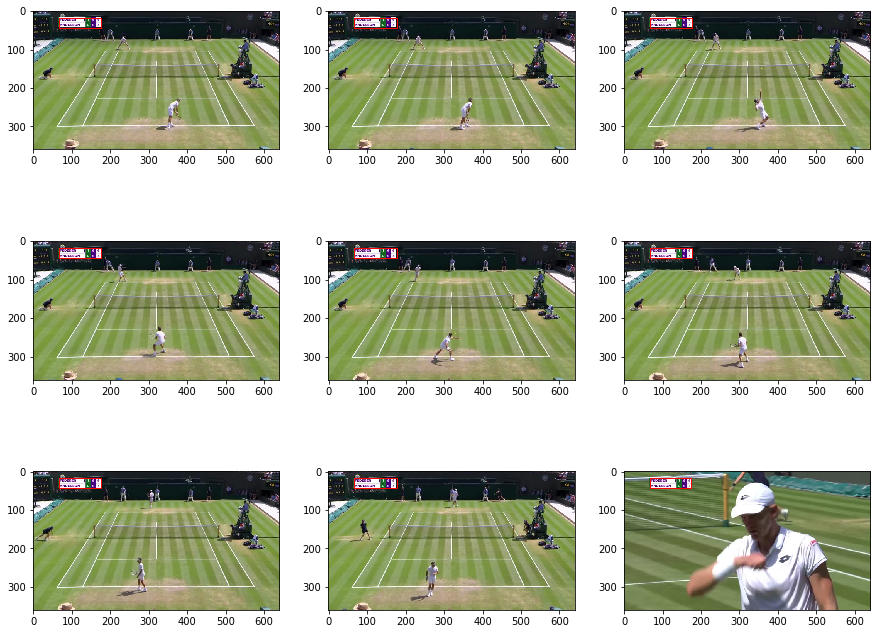

In [156]:
fig, axs = plt.subplots(3,3, figsize=(15, 12))
idx = 12
for i, ax in enumerate(np.array(axs).reshape(-1)):
    _im, _ = ds[idx + i]
    img = (_im[y:y+h, x:x+w] * 255)
    img = 255 - img if invert else img
    img = img.astype(np.uint8)
    ax.imshow(_im)
    dilated, _ = dilate_image(img, thresh_low=thresh_low)
    score_width = find_text(dilated, min_w=min_w, min_h=min_h)
    rect = Rectangle((x, y), score_width, h, linewidth=1, edgecolor='r', facecolor='none')
    ax.add_patch(rect)

In [157]:
match_metas[match_name] = match_meta

In [158]:
with open(meta_file, 'w') as f:
    json.dump(match_metas, f)